# Assignment 1

__Note__: *For general instructions about Assignment 1 as well as deadlines, please refer to the acompanying PDF document on Studium.*

### Setup

This notebook is there to help you complete Assignment 1. It contains 3 sections (one for each task of the assignment) that guide you through the processes of completing the assignment. First import the required libraries:

In [2]:
%matplotlib widget

In [3]:
import cv2
import numpy as np
from numpy import genfromtxt as gft
from ipywebrtc import CameraStream, VideoRecorder
from src.app import AnnotationApp
from src.landmark_names import landmark_names
from imageio import v3 as iio
from numpy.lib.stride_tricks import as_strided
import matplotlib.pyplot as plt
from src.skbot_replacement import linear_trajectory
from zipfile import ZipFile
from IPython.display import YouTubeVideo
import pandas as pd
import csv

In [4]:
gestures = [
    "ASL_letter_A",
    "ASL_letter_B",
    "ASL_letter_C",
    "ASL_letter_L",
    "ASL_letter_R",
    "ASL_letter_U",
]

### Metadata

This notebook will generate the files you have to upload in completion of Task 1 and Task 2. In order to ensure that these files will be named correctly, update the variables below with the appropriate values:

In [5]:
# update the variables below to the correct values
last_name = "SAGAR"
first_name = "TAMBRAHALLI"
student_number = "199712202499"

# Task 1 - Anonymized Videos

### Recording the Gestures

Task 1 asks you to record a total of 6 videos of your hand (6 seconds per video), with each video showing a different gesture. The required gestures change from year to year, so please refer to the instruction document for Assignment 1 for the exact gestures that you will have to record.

Currently, the overarching theme is american sign language (ASL) and below you can find a visualization of the ASL alphabet:

![ASL Alphabet](https://t3.ftcdn.net/jpg/02/42/65/88/360_F_242658839_l38u5LVWSROrFMLQasxLJgl6sk8yAq9m.jpg)
(Source: Adobe Stock)

**Important:** While recording the videos move your hand around slowly. For this, pick a constant direction (in 3D) and move your hand slowly in that direction. This is done to create more diverse training data. The hand can be anywhere on the screen, arbitrarily rotated, and at any distance from the camera (as long as it is still clearly identifiable as a hand). The broader the set of examples, the more robust the trained model will be.

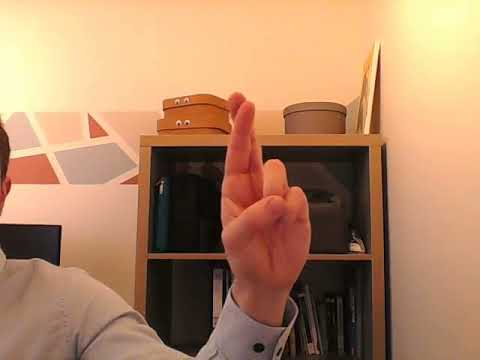

In [5]:
YouTubeVideo("VSu_Nkn7TzY")

_Example 1_: Place your hand on the left side of the image, show the gesture and start recording. Then - over the course of 6 seconds - slowly move your hand to the right side of the image.

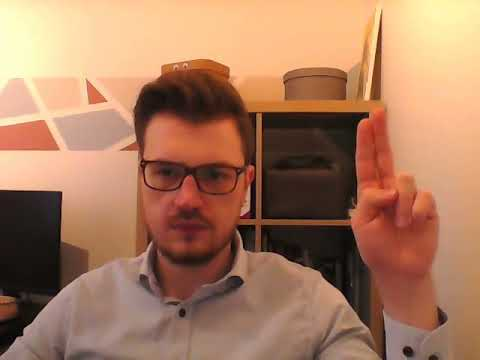

In [6]:
YouTubeVideo("ZEdfzmMntHs")

_Example 2_: Place your hand in the bottom of the image, show the gesture and start recording. Then - over the course of 6 seconds - move your hand up towards the top of.

*__Note__: We will aggregate the videos from all assignments into a large dataset that you will use during the final project. For this you will anonymize the recorded videos in the next step by blurring your face. If you feel that this level of anonymization is insufficient, you can avoid recording your face or use another means of anonymization.*

In [32]:
camera = CameraStream(constraints=
                      {'facing_mode': 'user',
                       'audio': False,
                       'video': { 'width': 640, 'height': 480}
                       })
camera

CameraStream(constraints={'facing_mode': 'user', 'audio': False, 'video': {'width': 640, 'height': 480}})

In [33]:
recorder = VideoRecorder(stream=camera)
recorder

VideoRecorder(stream=CameraStream(constraints={'facing_mode': 'user', 'audio': False, 'video': {'width': 640, …

In [34]:
camera.close()

Once you are happy with the video save it as a MP4 file. The filename should be the name of the gesture that has been recorded. For example, if you recorded the letter A, then the filename would be `ASL_letter_A.mp4`.

In [35]:
gesture_name = "ASL_letter_U"

In [36]:
with iio.imopen(recorder.video.value, "r", format="ffmpeg") as video_in:
    frames = video_in.read()

iio.imwrite(f"{gesture_name}.mp4", frames, fps=30)

**Please review the videos before you continue** and ensure that:

-	The name of the file must match the gesture shown in the video
-	The video must be in MP4 format
-	The gesture is shown for at least 6 seconds
-	The hand showing the gesture is not occluded by any objects
-	The hand showing the gesture does not occlude your face (if present)
-	The video must be anonymized

If your video does not satisfy the above, __we will reject it__ and you will have to record it again (and redo the annotations for that video).

### Anonymizing the Video

Run the snippet below. It uses the face detection method presented in lab 1 to track your face and then applies gaussian blur to it.

In [37]:
for condition in gestures:
    frames = iio.imread(f"{condition}.mp4")
    face_cascade = cv2.CascadeClassifier('frontal_face_features.xml')

    # find the face in each frame (only keep exact matches)
    timestamps = list()
    face_coords = list()
    for idx, frame in enumerate(frames):
        faces = face_cascade.detectMultiScale(frame)
        if len(faces) == 1:
            timestamps.append(idx)
            face_coords.append(faces[0])
            
    if timestamps == 0:
        # no faces detected
        iio.imwrite(f"{condition}_anonymous.mp4", frames, fps=30)
        continue
    
    # Track the faces across frames and smooth the track
    if timestamps[0] != 0:
        timestamps.insert(0, 0)
        face_coords.insert(0, face_coords[0])
    if timestamps[-1] != len(frames):
        timestamps.append(len(frames))
        face_coords.append(face_coords[-1])
    t_control = np.stack(timestamps)
    face_coords = np.stack(face_coords)  
    face_coords_interpolated = linear_trajectory(np.arange(len(frames)), face_coords, t_control=t_control)
    face_coords_interpolated = np.round(face_coords_interpolated).astype(int)
    
    old_shape = face_coords_interpolated.shape
    shape = (old_shape[0] - 5, old_shape[1], 5)
    old_strides = face_coords_interpolated.strides
    strides = (*old_strides, old_strides[0])    
    face_coords_smoothed = np.round(as_strided(face_coords_interpolated, shape, strides).mean(-1)).astype(int)

    # blurr the tracked area
    # 1. extract the face ROI in each frame
    # 2. apply incrementally apply mild blurs to incrementally larger areas
    #    (this gives the final result a smoother look)
    for frame, pos in zip(frames, face_coords_smoothed): 
        for partition in range(3, 10):
            inner = pos.copy()
            inner[0] = pos[0] + 1/partition * pos[2]
            inner[1] = pos[1] + 1/partition * pos[3]
            inner[2] = (partition-2)/partition * pos[2]
            inner[3] = (partition-2)/partition * pos[3]

            (x, y, w, h) = inner
            roi = frame[y:y+h, x:x+w]   
            roi = cv2.GaussianBlur(roi,(21, 21), 50)
            frame[y:y+h, x:x+w] = roi

        x, y, w, h = pos
        roi = frame[y:y+h, x:x+w]   
        roi = cv2.GaussianBlur(roi,(11, 11), 50)
        frame[y:y+h, x:x+w] = roi

    # write the frames to disk
    num_frames = len(face_coords_smoothed)
    iio.imwrite(f"{condition}_anonymous.mp4", frames[:num_frames], fps=30)

Inspect the anonymized videos and make sure that you are happy with the result of the anonymization. Also check that the gesture is still clearly visible and not affected by the annonymization. If not, please re-record the video in question and repeat the anonymization process.

### Prepare Task 1 for submission

After you have generated all the videos, group them into a zip file that can be uploaded to Studium. For this, make sure you have updated the values of the variables defined in the **Metadata** section above. Then, run the snippet below to generate the ZIP file.

In [38]:
with ZipFile(f"{last_name}_{first_name}_{student_number}_videos.zip", "w") as zipy:
    for condition in gestures:
        zipy.write(f"{condition}_anonymous.mp4", f"{condition}.mp4")

# Task 2 - Annotating the Videos

Annotate the videos that you have created in Task 1. This task will show you some of the challenges associated with "real world" ML projects and it tends to be the most disliked step in a ML project. It is, however, one of the most crutial ones, and the better the quality of your annotations is, the better your resulting model tends to be. To help you along in this process, we provide you with an annotation tool.

**Important:** This step is crucial for good performance of your machine learning model. ML is not black magic, and your model can only ever be as good as the data you use for training. If you are sloppy here, you will not have high performance later. The saying "trash in, trash out" is very true.

#### How to annotate the gestures:

*__Note__: If the annotation is lacking in accuracy, we will ask you to re-annotate the video before you can pass assignment 1.*

0. Only annotate <u>visible</u> joints.
1. Go to the first frame of the gesture.
2. Place the respective joint markers onto each joint according to the figure on the right.
3. Go to the last frame of the gesture.
4. Move the respective joint markers to their correct position in the last frame.
5. Go back to the first frame of the gesture.
6. Slowly move the "Frames" slider forward. Whenever you see that a marker deviates from the hand's joint, adjust it so that it follows the hand again.
7. After all videos are annotated, click the "Save CSV" button in the top left corner to create the CSV containing the annotations. It will be placed next to the notebook.

#### How to use this annotation tool:

1. Use the "Video" drop-down menu to select and jump between gestures (progress is preserved).
2. Move the "Frames" slider at the bottom to select individual frames (progress is preserved).
3. Click on the figure on the right, use the blue arrows on the bottom, or use the "Joint" drop-down menu to select a joint to annotate.
4. Click on the image on the left to place the respective joint marker. This will automatically jump to the next joint.
5. The marker matching the currently selected joint will turn red and you can drag it around in the image.
5. Use the blue buttons with label "Keyframe" to jump to the next (or previous) frame that had the current joint marker placed on it explicitly.
6. Use the red "🗑️ Keyframe" button to delete the annotation of the current joint at the current frame. This will have no effect if the current frame is not a keyframe.
7. Use the red "Reset Joint" button to delete all keyframes for the current joint.

#### Example Video of an Annotation

In [ ]:
YouTubeVideo("9UYYc_L3E34")

#### The Annotation Tool

In [39]:
%%capture
gui = AnnotationApp(gestures, f"{last_name}_{first_name}_{student_number}")

In [40]:
gui

### Information Sheet and Consent Form

Please review (and sign) the __Information Sheet and Consent Form__ document that was distributed with this assignment.


# Task 3 - Annotated Videos

Visualize the annotations (CSV from task 2) on top of each gesture (video from task 1). For this, draw circles onto each frame at the position of each visible joint. Then, draw lines that connect all pairs of visible joints that are adjacent according to the skeleton. This should result in a skeleton drawn onto the frame similar to the skeleton you saw while annotating the videos. Finally, add the text "annotated" into the top left corner of the frame and save the frames of each gesture as a new video.

Here is the program/algorithm in pseudo-code:

```
for each video in gestures:
    for each frame in video:
        place a label into the top left corner that reads "annotated"
        get the corresponding joint positions from the CSV file
        draw a circle at each (non-missing) joint position
        for each pair of visible joints connected by the skeleton:
            draw a line between the two joints using cv2.line
    create a new_video file called <gesture>_annotated from the annotated frames
```


In [42]:
j=1
my_data = gft('SAGAR_TAMBRAHALLI_199712202499.csv', delimiter=',')
window_name = "Test"
myframes, x, y = my_data[:, 2],my_data[:, 4], my_data[:, 5]
print(x[350])
for video in gestures:
    frames = iio.imread(f"{video}.mp4")
    #print(frame[0])
    for frame in frames:
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, 
                'ANNOTATED', 
                (50, 50), 
                font, 1, 
                (0, 255, 255), 
                2, 
                cv2.LINE_4)
        iio.imwrite(f"{video}_annotated.mp4", frames, fps=30)
        for j in range(34042):
            cv2.putText(frame, 
                'O', 
                (int(x[j]), int(y[j]), 
                font, 1, 
                (0, 255, 255), 
                2, 
                cv2.LINE_4)               
        #cv2.circle(frame,(my_data[:, 4],my_data[:, 5],5,(0,255,0))
        iio.imwrite(f"{video}_annotated.mp4", frames, fps=30)
 


SyntaxError: invalid syntax (Temp/ipykernel_9720/4081814679.py, line 28)

In [41]:
def get_joint_position (index, anon_video): 
    n = 0
    with open('SAGAR_TAMBRAHALLI_199712202499.csv', newline='') as csvfile: 
        spamreader = csv.DictReader(csvfile)
        result = {}
        for row in spamreader:
            if anon_video == row['gesture']:
                if str(index) == row['frame']:
                    result[row['joint']]= [float(row['x']), float(row['y'])]
    return(result)
joints = {0: ['root', 'thumb_1', 'thumb_2', 'thumb_3'], 
          1: ['root', 'index_1', 'index_2', 'index_3', 'index_4'],
          2: ['root', 'middle_1', 'middle_2', 'middle_3', 'middle_4'], 
          3: ['root', 'ring_1', 'ring_2', 'ring_3', 'ring_4'],
          4: ['root', 'pinky_1', 'pinky_2', 'pinky_3', 'pinky_4']}
colors = {0: [0,150,255], 1: [255,150,0], 2: [0,255,75], 3: [255,50,50], 4: [150,100,255]}

In [42]:
text_string = "ANNOTATED"
position = (10, 10) # pixels from the image's top Left to the text's bottom left.
font = cv2.FONT_HERSHEY_SIMPLEX
font_size = 1
font_color= (255, 0, 0) # Remember: BGR.
font_thickness = 3

for index, anon_video in enumerate(gestures): 
    frames= iio.imread (f"{anon_video}.mp4")
    for idx, image in enumerate(frames):
        cv2.putText(image, text_string, position, font, font_size, font_color, font_thickness) 
        positions = get_joint_position(idx, anon_video) 
        line_pos = {0: [], 1: [], 2: [], 3: [], 4: []}
        for pos in positions.keys():
            cX = round (positions [pos][1], 2) 
            cY = round (positions [pos][0], 2)
            if cX != 0 and cY != 0:
                cv2.circle (image, (int (cX), int (cY)), 6, (0, 0, 0), -1)
        for i in range (5):
            for j in range (len (joints[i])-1):
                cX = int(round(positions[joints[i][j]][0],2))
                cY = int(round(positions[joints[i][j]][1],2)) 
                dX = int(round(positions[joints[i][j+1]][0],2))
                dY = int(round(positions[joints[i][j+1]][1],2))
                if cX != 0 and cY != 0 and dX != 0 and dY != 0:
                    cv2.line(image, (cY, cX), (dY, dX), colors[i],2) 
    iio.imwrite(f"{anon_video}_annotated.mp4", frames, fps=30)

Once you are done, combine the annotated videos into a ZIP file using the snippet below.

In [43]:
with ZipFile(f"{last_name}_{first_name}_{student_number}_annotated.zip", "w") as zipy:
    for condition in gestures:
        zipy.write(f"{condition}_annotated.mp4")

## Upload to Studium

Once you are done, upload the following files to Studium:

1. The filled out and signed *Information Sheet and Consent Form*
2. The ZIP file with the anonymous videos (`<last name>_<first name>_<student number>_videos.zip`)
3. The CSV file containing the annotations (`<last name>_<first name>_<student number>.csv`)
4. the ZIP file with the annotated videos (`<last name>_<first name>_<student number>_videos_annotated.zip`)